### Import libraries

In [1]:
# Importación de las librerías necesarias
!pip install yellowbrick
import numpy as np
import pandas as pd
# Puede que nos sirvan también
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)  # Para mayor determinismo

## 1.Carga de datos

Al final del practico anterior obtuvimos un dataset enriquesido con features georeferenciadas. Es el momento de utilizarlo.

Exporta el dataframe obtenido en el ultimo practico a un csv y cargalo como dataframe.

In [2]:
dataframe = pd.read_csv('./data/curated_data.csv', sep='\t')
dataframe

,COD_ID,CONJ,MUN,ARE_LOC,geometry,UNI_TR_S,DIC,FIC,CNAE,ENE_01,...,n_close_con,is_urb,NODE,ENDNODE,g_degree,g_avg_ndeg,g_pagerank,g_dispersion,eigenvector_centrality,dist_to_trs_dijkstra
0,4_1040341,12737,2805802,NU,POINT (627712.6169779997 8776098.670127511),1_SESAQ_1,7.050,8.0,0,147,...,1,False,45297,44304,2,2.0,0.000012,"{'45298': 0.0, '45296': 0.0}",5.680527e-06,110
1,4_1040306,12737,2805802,NU,POINT (626353.4179798126 8777498.606078334),1_SESAQ_1,5.470,7.0,0,275,...,1,False,45268,44304,1,2.0,0.000007,{'45269': 0.0},2.625699e-06,126
2,4_1040035,12737,2805802,NU,POINT (635724.1370160332 8773322.662057359),1_SESAQ_1,7.130,7.0,0,1732,...,14,False,46283,44304,2,2.0,0.000012,"{'46285': 0.0, '46282': 0.0}",4.072908e-07,240
3,4_1040036,12737,2805802,NU,POINT (638696.4859638879 8773991.73208276),1_SESAQ_1,5.190,6.0,0,692,...,9,False,46525,44304,1,3.0,0.000006,{'46408': 0.0},7.984421e-07,233
4,4_1040038,12737,2805802,NU,POINT (638310.7990282972 8773035.106081862),1_SESAQ_1,5.840,7.0,0,1297,...,10,False,46406,44304,2,2.0,0.000012,"{'46438': 0.0, '46517': 0.0}",3.746185e-07,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,8_1080578,12730,2802809,NU,POINT (653013.3989592987 8739601.889035663),1_SECON_1,21.510,10.0,0,1206,...,12,False,65017,68429,2,2.0,0.000012,"{'65016': 0.0, '65018': 0.0}",4.457296e-07,321
8829,8_1080577,12730,2802809,NU,POINT (653309.3439843655 8739968.353031982),1_SECON_1,21.510,10.0,0,1469,...,8,False,64978,68429,2,2.0,0.000012,"{'65005': 0.0, '65004': 0.0}",2.614774e-07,334
8830,12_1120421,12730,2807600,NU,POINT (644710.9110109408 8734252.079058295),1_SECON_1,21.130,9.0,0,189,...,1,False,65134,68429,1,2.0,0.000007,{'65245': 0.0},1.424013e-07,434
8831,8_1080557,12730,2802809,NU,POINT (673768.0680233241 8730109.019107511),1_SECON_1,11.435,6.0,0,69,...,4,False,680043,71128,1,2.0,0.000007,{'680042': 0.0},1.931153e-07,139


Ahora debemos eliminar variables que no aporte informacion por ejemplo:


*   Indices y IDs
*   Referencias a otras tablas
*   Variables compuestas (listas, jsons, geometrias)

Identifica las variables que cumplen este criterio y eliminelas del dataset. Retira tambien la variable de salida que no van a utilizar FIC o DIC.

In [3]:
# Eliminar índices, IDs y variables compuestas.
dataframe.drop(
    columns=[
        'COD_ID', 'PAC_1', 'PAC_2', 'geometry', 'TR_S_geometry',
        'g_dispersion', 'TR_S_COD_ID', 'UNI_TR_S', 'TR_S_BARR_1',
        'TR_S_BARR_2'
    ],
    inplace=True,
    errors='ignore'
)

# Eliminar las siguientes variables dado que:
# TR_S_BARR_3 == '' para todas las filas,
# DIST == 46 para todas las filas,
# CONF == 'RA' para todas las filas excepto una,
# POSTO == 'PT' para todas las filas,
# BANC == 0 para todas la filas,
# MRT == 0 para todas la filas,
# DESCR = '' para todas las filas,
# SIT_ATIV = 'AT' para todas las filas excepto una,
# TIP_UNID = 38 para todas las filas,
# ATRB_PER = 1 para casi todas las filas,
# CAP_CHA = 1 para casi todas las filas,
# POS = 'PD' para casi todas las filas.
dataframe.drop(
    columns=[
        'TR_S_BARR_3', 'DIST', 'CONF', 'POSTO', 'BANC', 'MRT', 'DESCR',
        'SIT_ATIV', 'TIP_UNID', 'ATRB_PER', 'CAP_CHA', 'POS'
    ],
    inplace=True,
    errors='ignore'
)

# Eliminar DIC (vamos a usar FIC).
dataframe.drop(columns=['DIC'], inplace=True, errors='ignore')

# Con respecto a otras variables:
# DAT_CON y TR_S_DAT_CON son fechas. Nos sirven?
dataframe

,CONJ,MUN,ARE_LOC,FIC,CNAE,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,...,TIP_TRAFO,n_close_con,is_urb,NODE,ENDNODE,g_degree,g_avg_ndeg,g_pagerank,eigenvector_centrality,dist_to_trs_dijkstra
0,12737,2805802,NU,8.0,0,147,154,150,115,140,...,T,1,False,45297,44304,2,2.0,0.000012,5.680527e-06,110
1,12737,2805802,NU,7.0,0,275,236,263,256,204,...,T,1,False,45268,44304,1,2.0,0.000007,2.625699e-06,126
2,12737,2805802,NU,7.0,0,1732,1543,1413,1647,1632,...,MT,14,False,46283,44304,2,2.0,0.000012,4.072908e-07,240
3,12737,2805802,NU,6.0,0,692,650,604,697,728,...,MT,9,False,46525,44304,1,3.0,0.000006,7.984421e-07,233
4,12737,2805802,NU,7.0,0,1297,1175,1160,1370,1333,...,MT,10,False,46406,44304,2,2.0,0.000012,3.746185e-07,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,12730,2802809,NU,10.0,0,1206,1382,1062,1039,1006,...,MT,12,False,65017,68429,2,2.0,0.000012,4.457296e-07,321
8829,12730,2802809,NU,10.0,0,1469,1692,1402,1422,1460,...,MT,8,False,64978,68429,2,2.0,0.000012,2.614774e-07,334
8830,12730,2807600,NU,9.0,0,189,181,191,196,161,...,T,1,False,65134,68429,1,2.0,0.000007,1.424013e-07,434
8831,12730,2802809,NU,6.0,0,69,63,58,57,91,...,T,4,False,680043,71128,1,2.0,0.000007,1.931153e-07,139


## 2. Preprosecamiento y particion de datos

Siempre se recomienda partir los datos antes de realizar el preprocesamiento, y guardar el pipeline de transformacion para aplicar en operaciones futuras.

Sin embargo algunas operaciones principalmente la codificacion de variables puede realizarse antes de hacer la particion ya que no representa una interaccion entre las filas.

Genere una particion de datos en sets de entrenamiento y validacion.

In [5]:
# Partir conjunto de datos en conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(
    dataframe.drop(columns=['FIC']),
    dataframe.FIC,
    test_size=0.3,
    random_state=42
)

## 3. Preparacion de datos para regresion lineal

Los algoritmos de regresion solo aceptan entradas numericas, por lo tanto el primer paso que debemos realizar es codificar las variables categoricas numericamente.

Adicionalmente las diferencias en las dimensiones absolutas de las variables van a tener un impacto muy pronunciado en los coeficientes calculados por lo que tambien se recomienda realizar la normalizacion de las variables. 

Esto puede hacerse de varias maneras:

*   Media/Mediana y desviacion standard
*   Minimo y Maximo (Cuidado con los outliers)
*   De 1 a -1

Implemente una funcion o pipeline que aplique codificacion de variables categoricas y luego normalizacion. Recuerde que los parametros de normalizacion se calculan usando unicamente los valores de entrenamiento.

In [6]:
# Convertir CAP_ELO en una columna entera:
dataframe.CAP_ELO = dataframe.CAP_ELO.replace({
    '05H': '50', '1H': '100', '2H': '200', '3H': '300', '5H': '500',
    '6K': '6000', '10K': '10000', '15K': '15000'
}).astype('int')

In [7]:
dataframe.dtypes[dataframe.dtypes == 'object']

ARE_LOC         object
CNAE            object
TR_S_DAT_CON    object
PAC_3           object
FAS_CON_P       object
FAS_CON_S       object
FAS_CON_T       object
DAT_CON         object
CTMT            object
SUB             object
TIP_TRAFO       object
dtype: object

In [8]:
# Aplicar codificación one-hot para ARE_LOC
dataframe[['ARE_LOC_NU', 'ARE_LOC_UB']] = pd.get_dummies(dataframe.ARE_LOC)[['NU', 'UB']]

In [9]:
# Algunas filas tienen varios valores de CNAE. Esto ocurre porque hay algunos
# transformadores de distribución para los cuales existen dos o más
# actividades económicas populares entre sus consumidores.
# Como los casos son pocos, para simplificar el conjunto de datos, quedémonos
# sólo con un valor de CNAE para cada fila que tenga múltiples valores.
dataframe.CNAE = dataframe.CNAE.str.replace("'", "").str.strip('[]').apply(
    lambda value: value.split(' ')[-1]
)

In [10]:
# Aplicar codificación one-hot a CNAE (sólo valores más comunes).
cnae_counts = dataframe.CNAE.value_counts()
common_cnae_values = cnae_counts[:3].keys()
cnae_dummies = pd.get_dummies(dataframe.CNAE.apply(lambda value: 'CNAE_' + (value if value in common_cnae_values else 'uncommon')))
for dummy_col_name in cnae_dummies.columns:
    dataframe[dummy_col_name] = cnae_dummies[dummy_col_name]

In [11]:
# Quitar columnas que no sean numéricas.
dataframe.drop(
    columns=['ARE_LOC', 'CNAE', 'TR_S_DAT_CON', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'DAT_CON', 'CTMT', 'SUB', 'TIP_TRAFO'],
    inplace=True,
    errors='ignore'
)

dataframe

,CONJ,MUN,FIC,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,...,g_avg_ndeg,g_pagerank,eigenvector_centrality,dist_to_trs_dijkstra,ARE_LOC_NU,ARE_LOC_UB,CNAE_0,CNAE_3600601,CNAE_9900802,CNAE_uncommon
0,12737,2805802,8.0,147,154,150,115,140,162,148,...,2.0,0.000012,5.680527e-06,110,1,0,1,0,0,0
1,12737,2805802,7.0,275,236,263,256,204,367,275,...,2.0,0.000007,2.625699e-06,126,1,0,1,0,0,0
2,12737,2805802,7.0,1732,1543,1413,1647,1632,1553,1590,...,2.0,0.000012,4.072908e-07,240,1,0,1,0,0,0
3,12737,2805802,6.0,692,650,604,697,728,577,544,...,3.0,0.000006,7.984421e-07,233,1,0,1,0,0,0
4,12737,2805802,7.0,1297,1175,1160,1370,1333,1183,1149,...,2.0,0.000012,3.746185e-07,261,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,12730,2802809,10.0,1206,1382,1062,1039,1006,1098,1047,...,2.0,0.000012,4.457296e-07,321,1,0,1,0,0,0
8829,12730,2802809,10.0,1469,1692,1402,1422,1460,1618,1201,...,2.0,0.000012,2.614774e-07,334,1,0,1,0,0,0
8830,12730,2807600,9.0,189,181,191,196,161,114,203,...,2.0,0.000007,1.424013e-07,434,1,0,1,0,0,0
8831,12730,2802809,6.0,69,63,58,57,91,103,86,...,2.0,0.000007,1.931153e-07,139,1,0,1,0,0,0


In [13]:
dataframe.dtypes[dataframe.dtypes == 'object'] # no more non-numeric columns

Series([], dtype: object)

In [14]:
# Partir conjunto de datos en conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(
    dataframe.drop(columns=['FIC']),
    dataframe.FIC,
    test_size=0.3,
    random_state=42
)

In [16]:
# 2. Instancia y entrenamiento.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

/Users/brandonjanes/miniconda2/envs/inf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [17]:
# # 3. Predeciccion y evaluación.
# from sklearn.metrics import mean_squared_error
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_valid)

### Evaluacion del modelo

Para evaluar el modelo calcule R cuadrado, error medio absoluto y error medio cuadrado. Tanto de entrenamiento como de validacion.

In [18]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_valid, y_test_pred)
print(f'Train error: {train_error:2f}')
print(f'Test error: {test_error:2f}')

Train error: 9.965006
Test error: 10.257953


### Analisis de residuos

Otro punto importante en la evaluacion de los modelos de regresion, es no solo saber cuanto es el error sino como se distribuye. Para eso realizamos un analisis de residuos. Los residuos son simplemente las desviaciones de la prediccion al valor real.

Primero grafique la distribucion de los residuos.

Esta distribucion debe estar centrada en cero y deberia tender a ser simetrica.

**A continuacion genere un scatter plot entre la prediccion y el error.** 

Esto deberia verse principalmente como ruido, ya que no deberia haber correlacion entre estos valores.

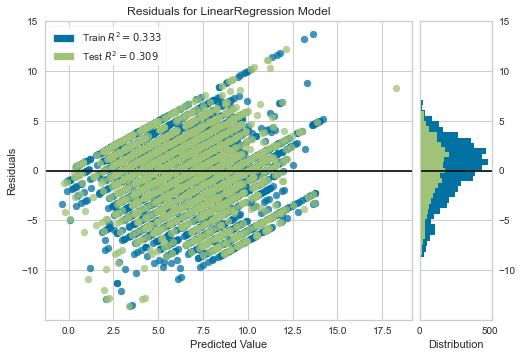

In [20]:
# scatterplot of residual error and distribution of residuals
visualizer = ResidualsPlot(lm)
visualizer.fit(X_train, y_train)
visualizer.score(X_valid, y_valid)
visualizer.show()

Finalmente el ultimo grafico que realizaremos es el QQ Plot, que nos indicara la distribucion del error a lo largo de los cuartiles.

**Genere un qq plot con las predicciones realizadas.**
(from statsmodels.graphics.gofplots import qqplot)

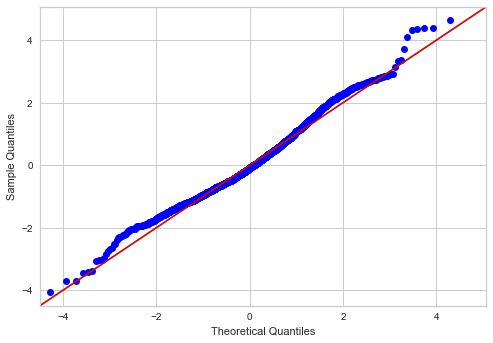

In [22]:
#from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as stats
res = (y_valid - y_test_pred)
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

En este caso los valores deben concentrarse sobre la linea diagonal.

#### Opcional:

La regularizacion es un metodo mediante el cual se penalisa el valor obsoluto de los coeficientes, de este modo se encuentran modelos mas estables y menos propensos a overfiear los datos.

Implemente una Regresion tipo Lasso (Regularizacion tipo L1) o tipo Ridge (Regularizacion tipo L2), calcula sus metricas y compare con la regresion lineal comun.

Compare the following results with **results from Linear Regression (simple)**:
```
Train error: 9.965006
Test error: 10.257953
```

In [24]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_valid)
train_error = mean_squared_error(y_train, y_train_ridge)
test_error = mean_squared_error(y_valid, y_test_ridge)
print(f'Train error: {train_error:2f}')
print(f'Test error: {test_error:2f}')

Train error: 9.968950
Test error: 10.247793


In [25]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_valid)
train_error = mean_squared_error(y_train, y_train_lasso)
test_error = mean_squared_error(y_valid, y_test_lasso)
print(f'Train error: {train_error:2f}')
print(f'Test error: {test_error:2f}')

Train error: 10.567768
Test error: 10.571906


/Users/brandonjanes/miniconda2/envs/inf/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32771.63549230752, tolerance: 9.240265971211391
  positive)


## 5. Importancia de las variables, Regresion Lineal

En base a la arquitectura del modelo y utilizando los coeficientes del modelo, determine cuales son las 10 variables de mayor peso en el modelo y explique porque.

Feature: 0, Absolute Value: 1.59519
Feature: 1, Absolute Value: 0.00001
Feature: 2, Absolute Value: 0.00017
Feature: 3, Absolute Value: 0.00009
Feature: 4, Absolute Value: 0.00014
Feature: 5, Absolute Value: 0.00009
Feature: 6, Absolute Value: 0.00002
Feature: 7, Absolute Value: 0.00004
Feature: 8, Absolute Value: 0.00009
Feature: 9, Absolute Value: 0.00007
Feature: 10, Absolute Value: 0.00008
Feature: 11, Absolute Value: 0.00001
Feature: 12, Absolute Value: 0.00004
Feature: 13, Absolute Value: 0.00007
Feature: 14, Absolute Value: 327347419976.40045
Feature: 15, Absolute Value: 11358752289377.92383
Feature: 16, Absolute Value: 13512862660469.84180
Feature: 17, Absolute Value: 20969991.68217
Feature: 18, Absolute Value: 2832655.18094
Feature: 19, Absolute Value: 99087.67764
Feature: 20, Absolute Value: 91485.87216
Feature: 21, Absolute Value: 340572.13204
Feature: 22, Absolute Value: 96760.76978
Feature: 23, Absolute Value: 128256.48995
Feature: 24, Absolute Value: 51690.34083
Feature: 

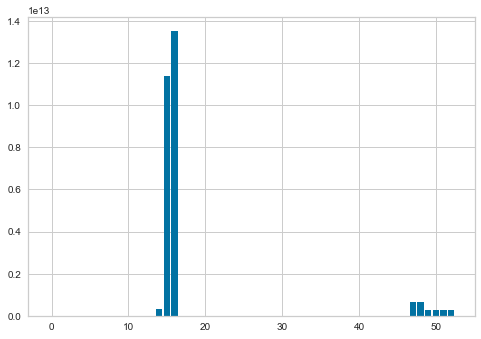

In [26]:
# get importance https://machinelearningmastery.com/calculate-feature-importance-with-python/
import matplotlib.pyplot as pyplot
importance = lm.coef_ #scaling??
# summarize feature importance

for i,v in enumerate(importance):
    #print(v)
    print('Feature: %0d, Absolute Value: %.5f' % (i,abs(v)))
    
#plot feature importance
pyplot.bar([x for x in range(len(importance))], abs(importance))
pyplot.show()

CONCLUSION: Apparently variables number 15 and 16 have a big sway over our models predictions.

## 6. Preparacion de datos para algoritmos basados en arboles

Otra rama muy utilizada de modelos son aquellos basados en arboles de decision, como Bagging, Random Forrest o Boosting. En nuestro caso utilizaremos una implementacion de Boosting por gradiente denominada XGBoost que es reconocida por producir muy buenos resultados.

Dada la naturaleza de los arboles de decision en este caso es necesario normalizar los datos. Para demostrarlo, entrene dos modelos con parametros por default, utilizando el dataset normalizado y sin normalizar.

In [29]:
dataframe.loc[:, dataframe.columns != 'FIC']

,CONJ,MUN,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,ENE_08,...,g_avg_ndeg,g_pagerank,eigenvector_centrality,dist_to_trs_dijkstra,ARE_LOC_NU,ARE_LOC_UB,CNAE_0,CNAE_3600601,CNAE_9900802,CNAE_uncommon
0,12737,2805802,147,154,150,115,140,162,148,202,...,2.0,0.000012,5.680527e-06,110,1,0,1,0,0,0
1,12737,2805802,275,236,263,256,204,367,275,241,...,2.0,0.000007,2.625699e-06,126,1,0,1,0,0,0
2,12737,2805802,1732,1543,1413,1647,1632,1553,1590,1554,...,2.0,0.000012,4.072908e-07,240,1,0,1,0,0,0
3,12737,2805802,692,650,604,697,728,577,544,593,...,3.0,0.000006,7.984421e-07,233,1,0,1,0,0,0
4,12737,2805802,1297,1175,1160,1370,1333,1183,1149,1206,...,2.0,0.000012,3.746185e-07,261,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,12730,2802809,1206,1382,1062,1039,1006,1098,1047,1126,...,2.0,0.000012,4.457296e-07,321,1,0,1,0,0,0
8829,12730,2802809,1469,1692,1402,1422,1460,1618,1201,1281,...,2.0,0.000012,2.614774e-07,334,1,0,1,0,0,0
8830,12730,2807600,189,181,191,196,161,114,203,147,...,2.0,0.000007,1.424013e-07,434,1,0,1,0,0,0
8831,12730,2802809,69,63,58,57,91,103,86,91,...,2.0,0.000007,1.931153e-07,139,1,0,1,0,0,0


In [30]:
import xgboost as xgb
X, y = dataframe.loc[:, dataframe.columns != 'FIC'],dataframe.loc[:, dataframe.columns == 'FIC']
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Evaluacion del modelo, XGBoost

Seleccione uno de los modelos, calcule las metricas y realize el analisis un analisis de residuos, similar al realizado anteriormente.

In [31]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [32]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [33]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.944996


## 7. Importancia de las variables

Utilize el metodo "Feature Importance" para determinar las 10 variables mas importante del modelo, verifique los diferentes criterios de calculo, seleccione uno y grafique sus coeficientes.

## 8. (Opcional) Conversion a problema de clasificacion

Podemos cambiar la naturaleza del problema de regresion a clasificacion simplemente cuantizando la salida y asignando una categoria cada intervalo.

Separe la salida en 5 intervalos segun su criterio, asignele categorias de 0 a 5, siendo 0 la peor calidad y 5 la mejor.

Entrene un classificador XGBoost, y calcule las metricas de accuracy, precision, recall, f1 score.

## 9. Conclusiones

A partir de todos los puntos anteriores exponga sus impresiones y conclusiones personales.